In [1]:
# Assignment 10
# Extended Kalman filter for navigation and tracking
# Team 2:
#     Ekaterina Karmanova
#     Timur Chikichev
#     Iaroslav Okunevich
#     Nikita Mikhailovskiy
#
# Skoltech, 16.10.2019

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
#1
def MatrixX(size,t):
        trajectory=np.zeros([4,size])        
        trajectory[0,0]=1000
        trajectory[1,0]=10
        trajectory[2,0]=1000
        trajectory[3,0]=10
        ax = np.random.normal(0,0.3,500)
        ay = np.random.normal(0,0.3,500)
        for i in range(1,size):
            trajectory[0,i]=trajectory[0,i-1]+trajectory[1,i-1]*t + (ax[i-1]*t**2)/2
            trajectory[1,i]=trajectory[1,i-1] + ax[i-1]*t
            trajectory[2,i]=trajectory[2,i-1]+trajectory[3,i-1]*t + (ay[i-1]*t**2)/2
            trajectory[3,i]=trajectory[3,i-1] + ay[i-1]*t
        return trajectory
    
trajectoryCartesian=MatrixX(500,1)

In [4]:
#2
def PolarTrajectory(matrixCartesian):
        trajectoryPolar=np.zeros([2,matrixCartesian.shape[1]]) 
        for i in range(0,matrixCartesian.shape[1]):
            trajectoryPolar[0,i]=np.sqrt(matrixCartesian[0,i]**2+matrixCartesian[2,i]**2)
            trajectoryPolar[1,i]=np.arctan(matrixCartesian[0,i]/matrixCartesian[2,i])
        return trajectoryPolar
trajectoryPolar=PolarTrajectory(trajectoryCartesian)

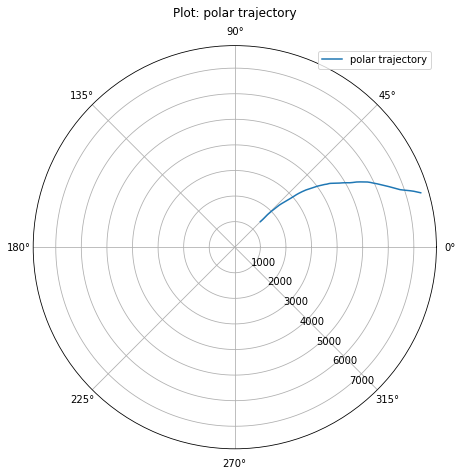

In [5]:
#ax = plt.subplot(111, projection='polar')
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
ax.plot(trajectoryPolar[1],trajectoryPolar[0],label='polar trajectory')
ax.set_title("Plot: polar trajectory", va='bottom')
ax.set_rlabel_position(-50.5)
ax.legend()
plt.show()  

In [6]:
#3
def Measurements(trajectoryPolar,nyD,nyB):
        z=np.zeros([2,trajectoryPolar.shape[1]])
        for i in range(0, trajectoryPolar.shape[1]):
            z[0,i]=trajectoryPolar[0,i]+nyD[i]
            z[1,i]=trajectoryPolar[1,i]+nyB[i]
        return z
sigmasTrue=[50,0.004]
nyD= np.random.normal(0, sigmasTrue[0], 500)
nyB= np.random.normal(0, sigmasTrue[1], 500)
z=Measurements(trajectoryPolar,nyD,nyB)

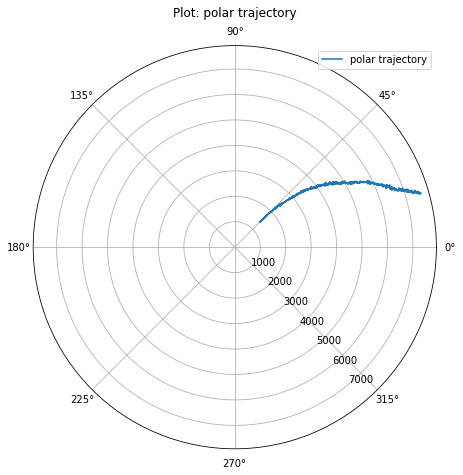

In [7]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
ax.plot(z[1],z[0],label='polar trajectory')
ax.set_title("Plot: polar trajectory", va='bottom')
ax.set_rlabel_position(-50.5)
ax.legend()
plt.show()  

In [8]:
#4,5
def MeasurementsXY(trajectoryPolarMeasurements):
        measurementsXY=np.zeros([2,trajectoryPolarMeasurements.shape[1]])
        for i in range(0, trajectoryPolarMeasurements.shape[1]):
            measurementsXY[0,i]=trajectoryPolarMeasurements[0,i]*np.sin(trajectoryPolarMeasurements[1,i])
            measurementsXY[1,i]=trajectoryPolarMeasurements[0,i]*np.cos(trajectoryPolarMeasurements[1,i])
        return measurementsXY
measurementsXY=MeasurementsXY(z)

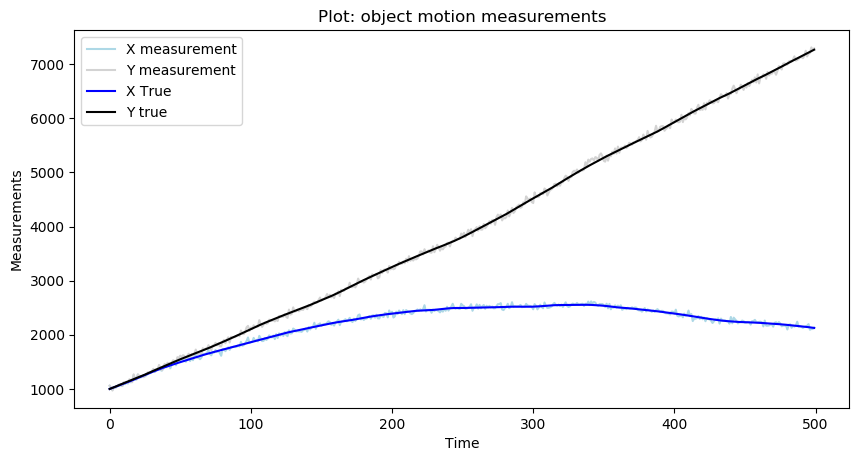

In [9]:
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: object motion measurements')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(measurementsXY[0],label='X measurement',color='lightblue')
plt.plot(measurementsXY[1],label='Y measurement',color='lightgrey')
plt.plot(trajectoryCartesian[0],label='X True',color='blue')
plt.plot(trajectoryCartesian[2],label='Y true',color='k')
plt.legend()
plt.show()  

In [10]:
#4
T = 1
x00=np.matrix([[z[0,0]*np.sin(z[1,0])],
              [0],
              [z[0,0]*np.cos(z[1,0])],
              [0]])
G=np.matrix([[T**2/2,0],
             [T,0],
             [0,T**2/2],
             [0,T]])
p00=np.eye(4)
p00*=10**10
#5
def SetupFi(t):
    fi=np.eye(4)
    fi[0,1]=t
    fi[2,3]=t
    return np.asmatrix(fi)
FI=SetupFi(T)

In [11]:
#6
Q = G.dot(G.T).dot(0.3**2)

In [12]:
#7
R=np.matrix([[sigmasTrue[0]**2,0],
             [0,sigmasTrue[1]**2]])

In [13]:
def XPrediction(fi,x):
    return fi.dot(x)

def PPrediction(p00,fi,q):
    return np.add(fi.dot(p00).dot(fi.T),q)

def FindKI(pI,h,r):
    onePart=pI.dot(h.T)
    secondpart=np.add(h.dot(pI).dot(h.T),r)
    return onePart.dot(np.linalg.inv(secondpart))

def FindPII(pI,k,h):
    return (np.subtract(np.eye(4),k.dot(h))).dot(pI)

def FindXI(xI,k,zI,h):
    return np.add(xI,k.dot(np.subtract(zI,h)))
#8
def FindH(xI):
    h = np.matrix([[np.sqrt(xI.item(0)**2+xI.item(2)**2)],
                   [np.arctan(xI.item(0)/xI.item(2))]])
    zn = (xI.item(0)**2+xI.item(2)**2)
    dh = np.matrix([[xI.item(0)/np.sqrt(zn),0,xI.item(2)/np.sqrt(zn),0],
                    [xI.item(2)/zn,0,-(xI.item(0)/zn),0]])
    return h,dh

In [14]:
#9
#def Kalman(z,h,fi,q,pFiltration=np.eye(4)*(10**10),x00,sigmasDB):
def Kalman(z,fi,q,r,pFiltration,x00,sigmasDB):
    arrayK=np.zeros(len(z.T))
    pFilterArray=np.zeros(len(z))
    tracjectKalman=np.zeros((4,z.shape[1]))
    tracjectKalman[0,0]=x00[0]
    tracjectKalman[1,0]=x00[1] 
    tracjectKalman[2,0]=x00[2]
    tracjectKalman[3,0]=x00[3]
    xc=x00
    #pFilterArray[0]=np.sqrt(pFiltration[0,0])
    for i in range(1,z.shape[1]): 
        xPred=XPrediction(fi,xc)
        pPrediction=PPrediction(pFiltration, fi, q)
        h,dh = FindH(xPred)
        k=FindKI(pPrediction,dh,r)
        zCartesian=np.matrix([[z[0,i]],
                              [z[1,i]]])
        xii=FindXI(xPred,k,zCartesian,h)
        pFiltration=FindPII(pPrediction,k,dh) 
        
        #pFilterArray[i]=np.sqrt(pFiltration[0,0])        
        tracjectKalman[0,i]=xii[0]
        tracjectKalman[1,i]=xii[1]
        tracjectKalman[2,i]=xii[2]
        tracjectKalman[3,i]=xii[3]
        xc = xii
    return tracjectKalman, pFilterArray
tracjectKalman, pFilterArray=Kalman(z,FI,Q,R,p00,x00,sigmasTrue)

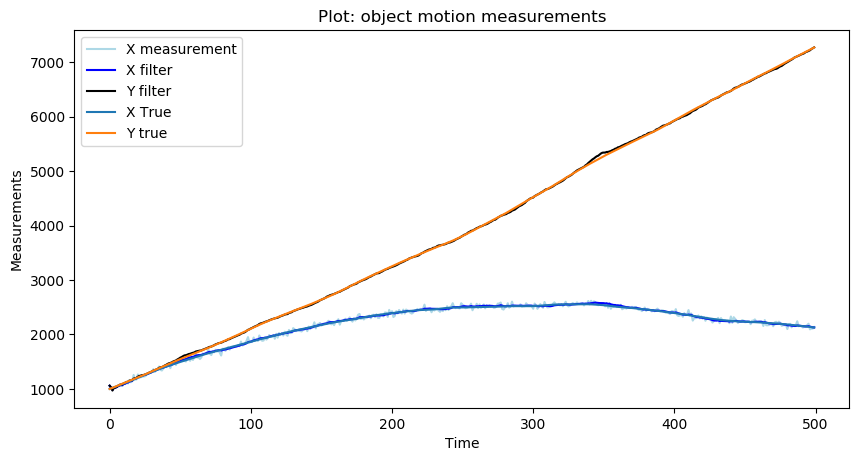

In [15]:
figure(num=None, figsize=(10, 5), dpi=100, facecolor='w', edgecolor='k')
plt.title('Plot: object motion measurements')
plt.ylabel('Measurements')
plt.xlabel('Time')
plt.plot(measurementsXY[0],label='X measurement',color='lightblue')
#plt.plot(measurementsXY[1],label='Y measurement',color='red')
plt.plot(tracjectKalman[0],label='X filter',color='blue')
plt.plot(tracjectKalman[2],label='Y filter',color='k')

plt.plot(trajectoryCartesian[0],label='X True')
plt.plot(trajectoryCartesian[2],label='Y true')
plt.legend()
plt.show()  

In [16]:
polarKalman = PolarTrajectory(tracjectKalman)

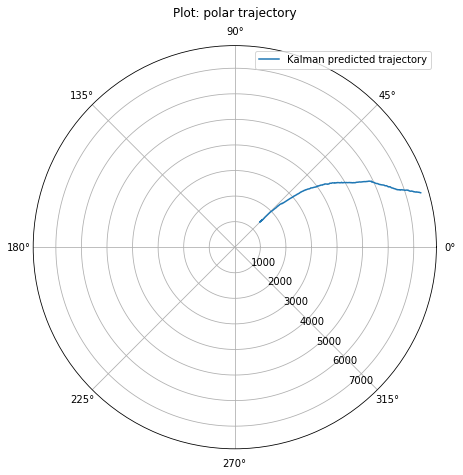

In [17]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection='polar')
ax.plot(polarKalman[1],polarKalman[0],label='Kalman predicted trajectory')
ax.set_title("Plot: polar trajectory", va='bottom')
ax.set_rlabel_position(-50.5)
ax.legend()
plt.show()  

In [24]:
#500 runs error calculation
def FinalError(FI,runs,pFiltration,x00,sigmasTrue,step=7):
    finalError=np.zeros((2,500))

    for i in range(runs):
        
        trajectoryCartesian=MatrixX(500,1)
        trajectoryPolar=PolarTrajectory(trajectoryCartesian)
        nyD= np.random.normal(0, sigmasTrue[0], 500)
        nyB= np.random.normal(0, sigmasTrue[1], 500)
        z=Measurements(trajectoryPolar,nyD,nyB)
        
        tracjectKalman, no_us = Kalman(z,FI,Q,R,pFiltration,x00,sigmasTrue)  
        for j in range(trajectoryCartesian.shape[1]):
            distance=np.sqrt(tracjectKalman[0,j]**2+tracjectKalman[2,j]**2)
            azimuth=np.arctan(tracjectKalman[0,j]/tracjectKalman[2,j])
            finalError[0,j]+=(trajectoryPolar[0,j]-distance)**2
            finalError[1,j]+=(trajectoryPolar[1,j]-azimuth)**2
            
            
    for i in range(trajectoryCartesian.shape[1]):
        finalError[0,i]=np.sqrt(finalError[0,i]/(runs-1)) 
        finalError[1,i]=np.sqrt(finalError[1,i]/(runs-1)) 
        
    return finalError

In [25]:
#Calculating true errors of estimation
finalError = FinalError(FI,500,p00,x00,sigmasTrue)

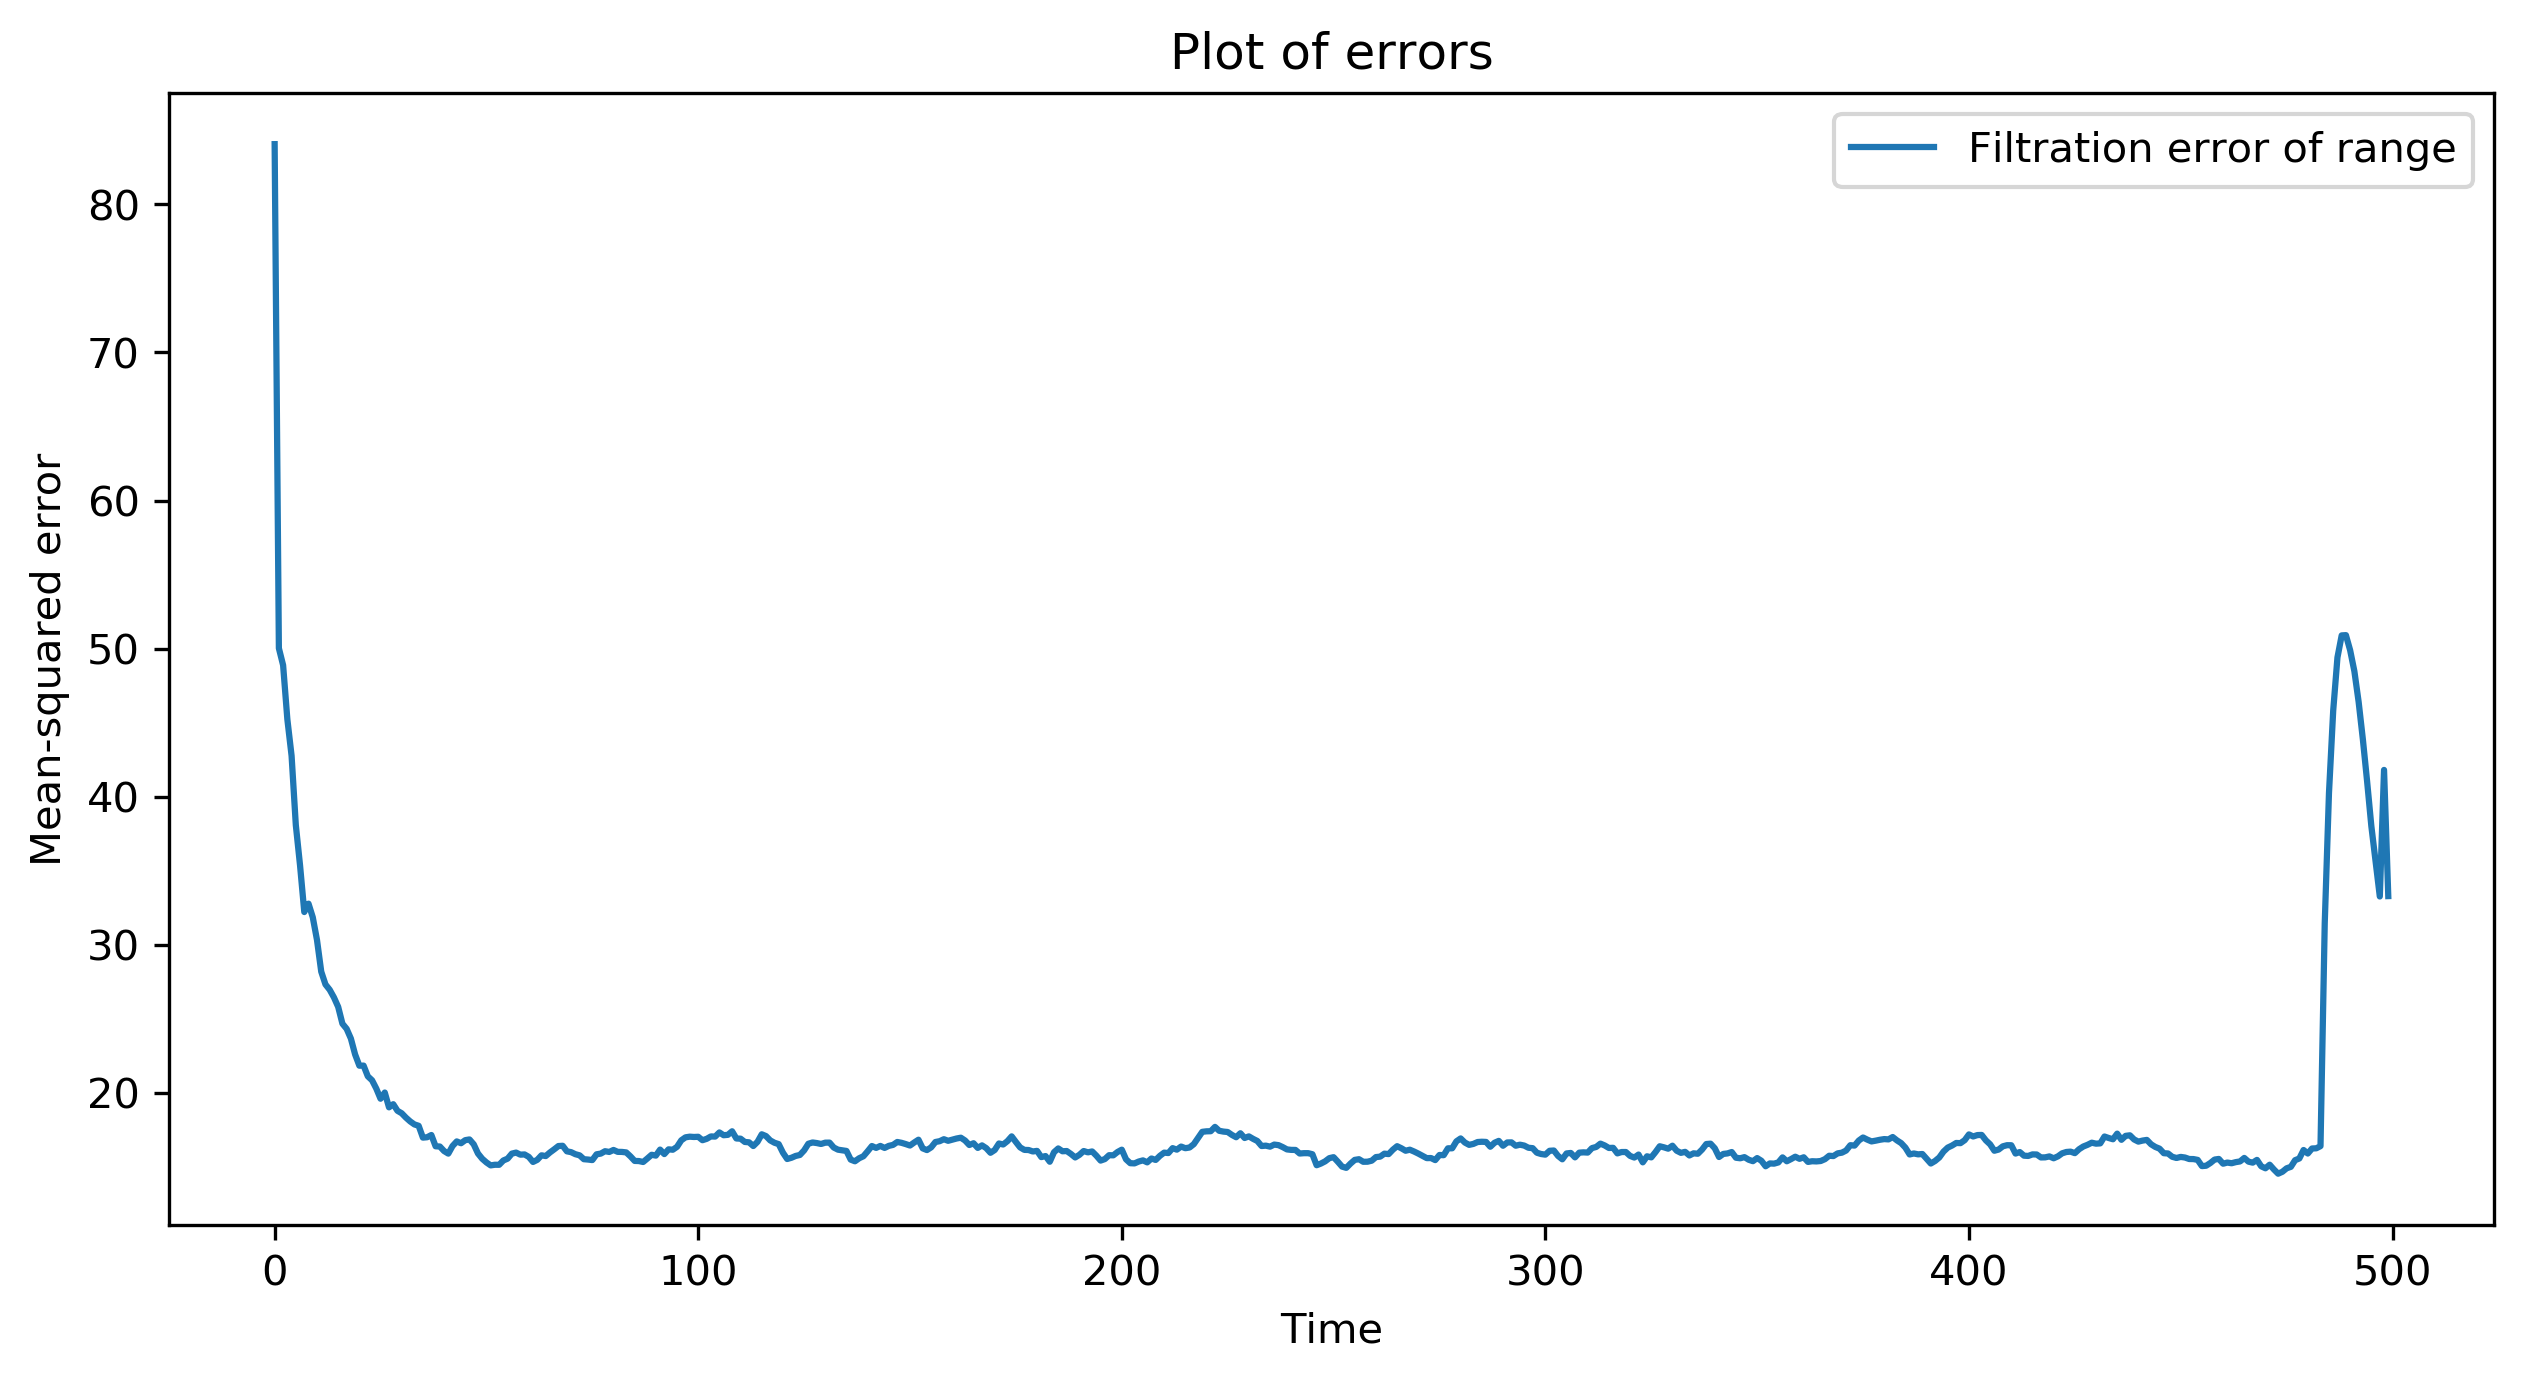

In [33]:
#Plots of relative errors
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot of errors')
plt.ylabel('Mean-squared error')
plt.xlabel('Time')
plt.plot(finalError[0],label='Filtration error of range')
plt.legend()
plt.show()  

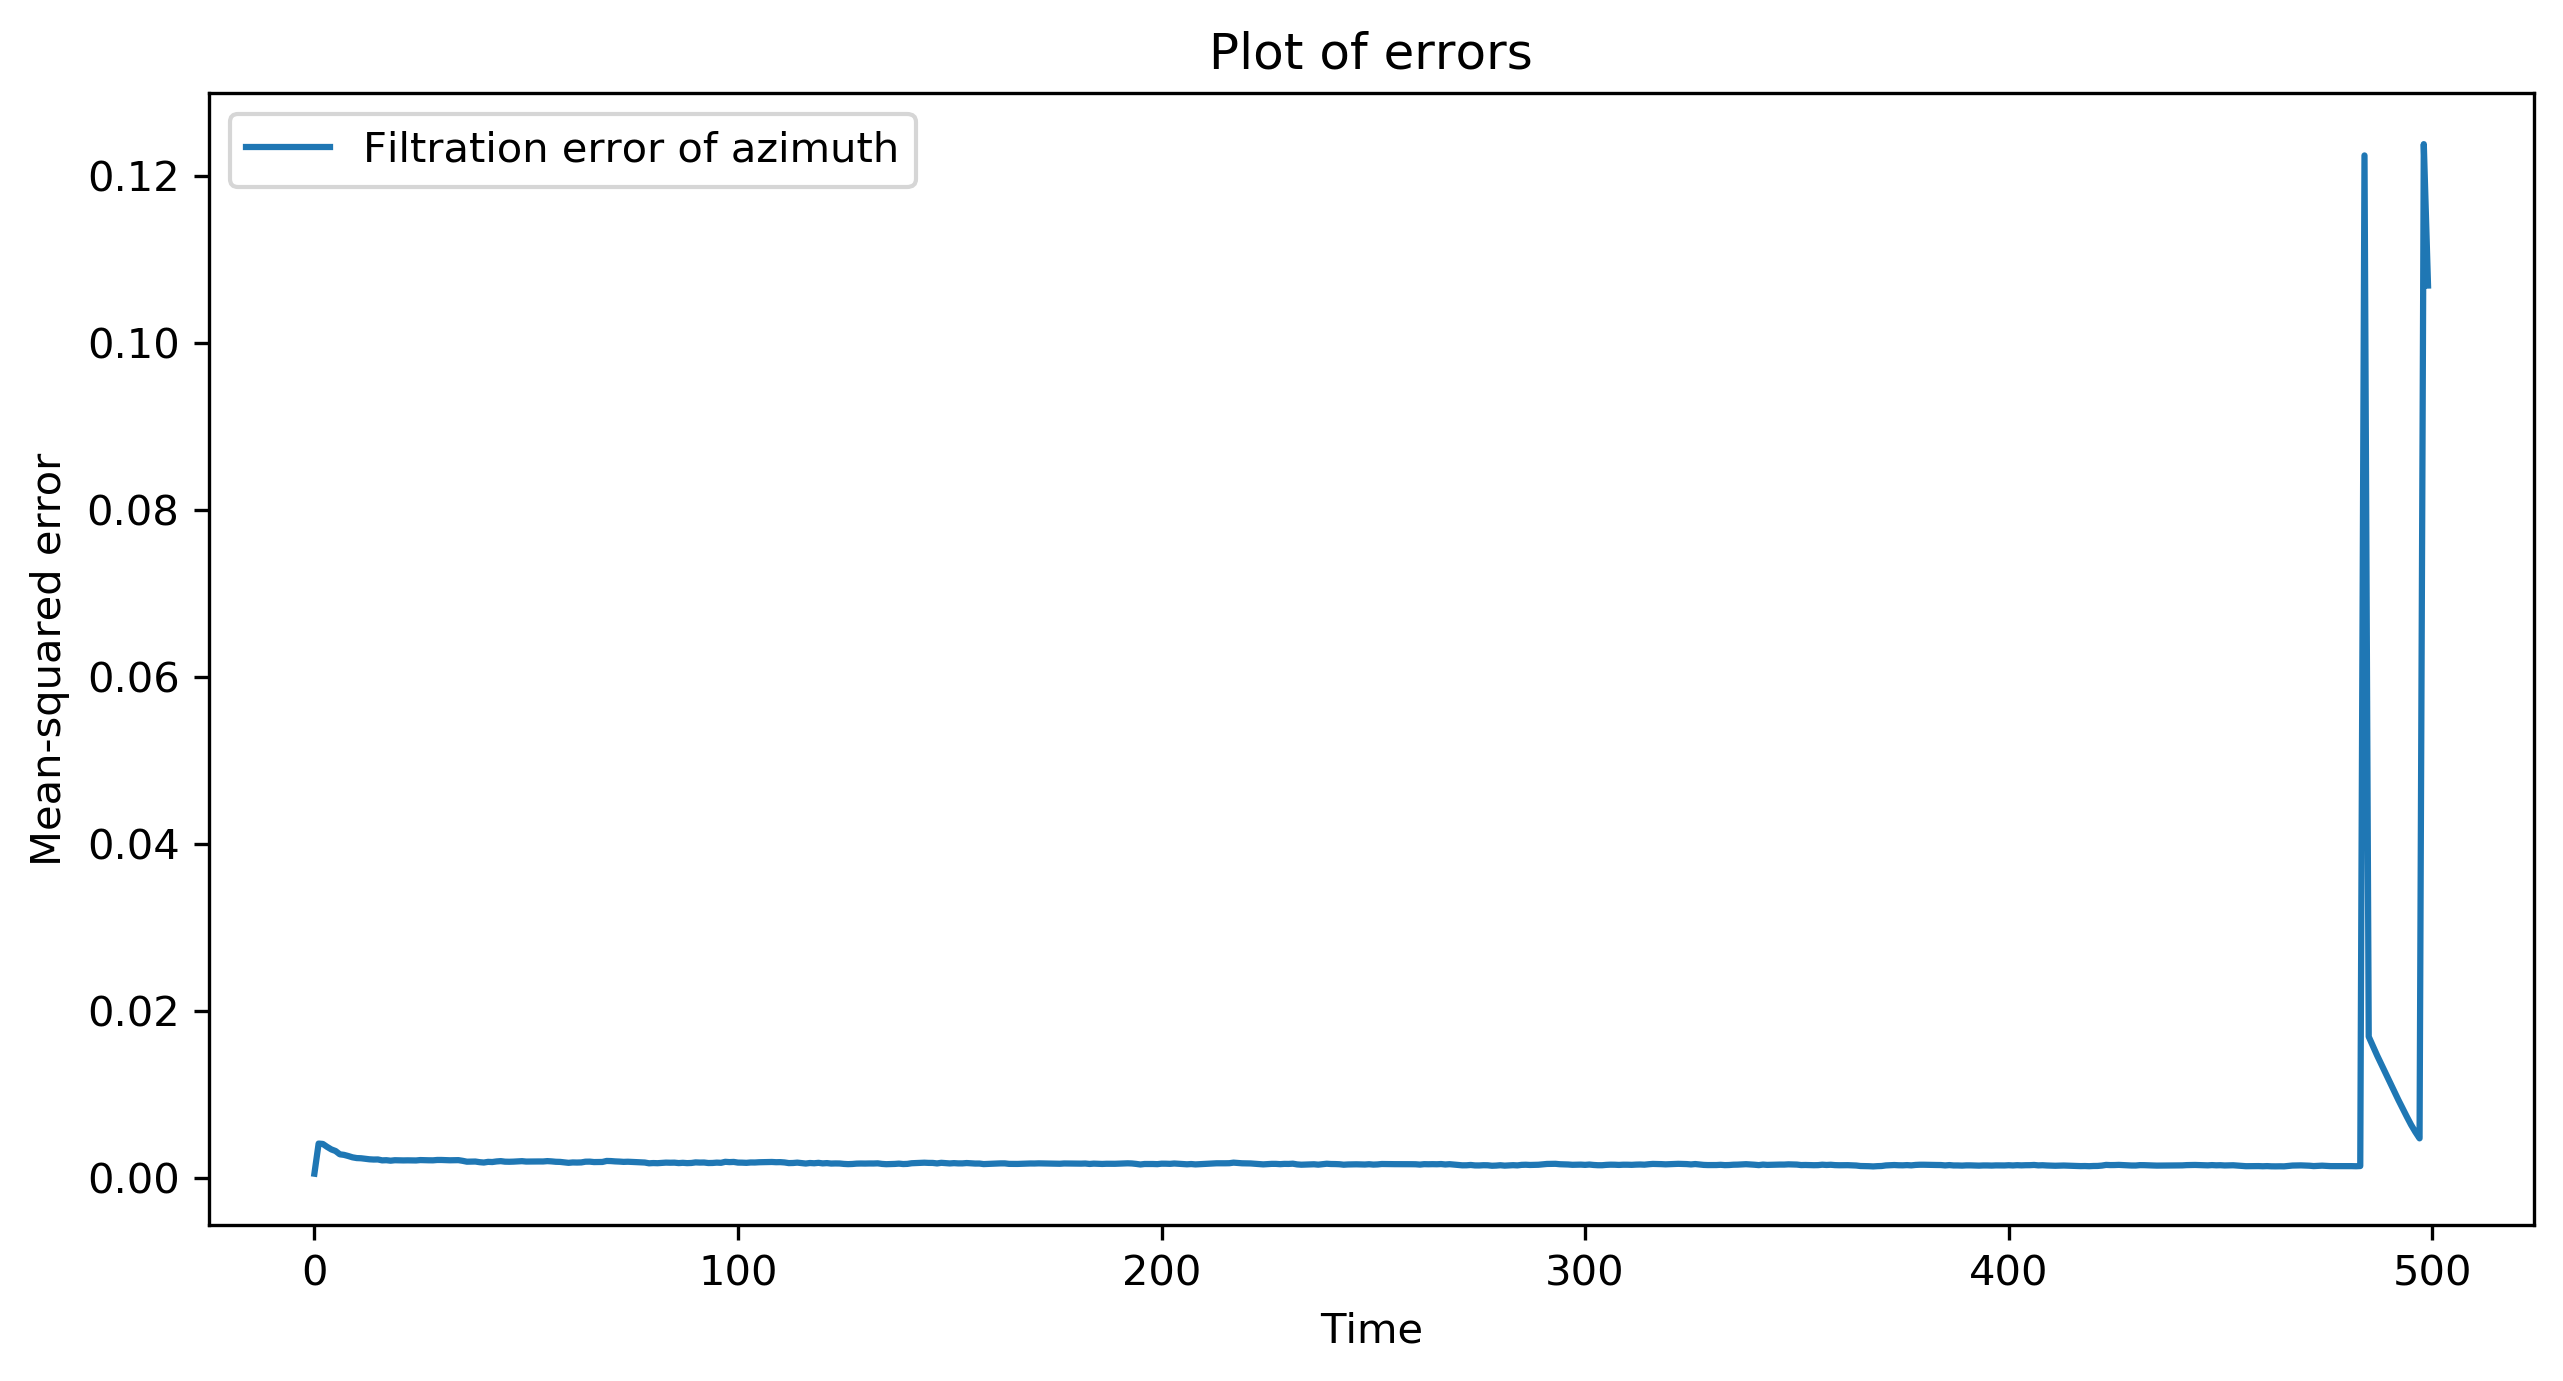

In [32]:
#Plot of relative errors
figure(num=None, figsize=(10, 5), dpi=300, facecolor='w', edgecolor='k')
plt.title('Plot of errors')
plt.ylabel('Mean-squared error')
plt.xlabel('Time')
plt.plot(finalError[1],label='Filtration error of azimuth')
plt.legend()
plt.show()  